In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import numpy as np


## Split Train/Test

### Chargement des données

1. Chargez le fichier `data.csv` avec pandas et affichez les premières lignes.

In [2]:
df = pd.read_csv("tp_fil_rouge_data.csv", encoding="unicode_escape")
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


2. Vérifiez les types de colonnes, les valeurs manquantes et les doublons.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
def analyze_missing_date(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    df_missing = pd.DataFrame(
        {
            "Colonnes": missing.index,
            "Valeurs manquantes": missing.values,
            "Pourcentages": missing_pct.values,
        }
    )
    df_missing = df_missing[df_missing["Valeurs manquantes"] > 0].sort_values(
        "Pourcentages", ascending=False
    )
    return df_missing


missing_data = analyze_missing_date(df)
print(missing_data.head(len(missing_data)))

      Colonnes  Valeurs manquantes  Pourcentages
6   CustomerID              135080     24.926694
2  Description                1454      0.268311


In [5]:
df_cleaned_na = df.dropna(subset="CustomerID")
print("Nombre de lignes supprimées : ", len(df) - len(df_cleaned_na))

Nombre de lignes supprimées :  135080


In [6]:
df_cleaned_doubloons = df_cleaned_na.drop_duplicates(
    [
        "InvoiceNo",
        "StockCode",
        "Description",
        "Quantity",
        "InvoiceDate",
        "UnitPrice",
        "CustomerID",
        "Country",
    ]
)
print("Nombre de doublons supprimés : ", len(df_cleaned_na) - len(df_cleaned_doubloons))

Nombre de doublons supprimés :  5225


3. Créez une colonne `churn` binaire : `1` si le client n'a pas commandé depuis plus de 90 jours, `0` sinon. Affichez la distribution de cette variable cible.

In [8]:
df_enriched = df_cleaned_doubloons.copy()

last_order = (
    df_enriched.groupby("CustomerID")
    .agg(last_order=("InvoiceDate", "max"))
    .sort_index()
)
last_order["Churn"] = last_order["last_order"].apply(
    lambda x: 1 if x < datetime(2011, 10, 1, 0, 0, 0) else 0
)

df_enriched = df_enriched.join(last_order, "CustomerID", "left")

df_enriched["Churn"].value_counts()

Churn
0    337808
1     63796
Name: count, dtype: int64

### Split des données

4. Séparez les features `X` et la cible `y`.

In [28]:
X = df_enriched[
    [
        # "InvoiceNo",
        # "StockCode",
        # "Description",
        "Quantity",
        "InvoiceDate",
        "UnitPrice",
        # "CustomerID",
        "Country",
    ]
].copy()
y = df_enriched["Churn"].copy()

5. Réalisez un **split simple** (80% train / 20% test) et affichez les proportions de chaque classe dans le train et le test.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape[0]} echantillons")
print(f"  Proportions: {np.bincount(y_train) / len(y_train)}")
print(f"Test:  {X_test.shape[0]} echantillons")
print(f"  Proportions: {np.bincount(y_test) / len(y_test)}")

Train: 321283 echantillons
  Proportions: [0.84135793 0.15864207]
Test:  80321 echantillons
  Proportions: [0.84030328 0.15969672]


6. Réalisez un **split stratifié** et comparez les proportions obtenues avec le split simple.

In [30]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train: {X_train_s.shape[0]} echantillons")
print(f"  Proportions: {np.bincount(y_train_s) / len(y_train_s)}")
print(f"Test:  {X_test_s.shape[0]} echantillons")
print(f"  Proportions: {np.bincount(y_test_s) / len(y_test_s)}")

Train: 321283 echantillons
  Proportions: [0.84114628 0.15885372]
Test:  80321 echantillons
  Proportions: [0.84114989 0.15885011]


In [31]:
original_props = np.bincount(y) / len(y)

# sans stratification
train_props = np.bincount(y_train) / len(y_train)
test_props = np.bincount(y_test) / len(y_test)
ecart_sans = np.abs(original_props - test_props).sum()

# avec stratification
train_props_s = np.bincount(y_train_s) / len(y_train_s)
test_props_s = np.bincount(y_test_s) / len(y_test_s)
ecart_avec = np.abs(original_props - test_props_s).sum()

print("Ecart total par rapport aux proportions originales")
print(f"Sans stratification (test): {ecart_sans}")
print(f"Avec stratification (test): {ecart_avec}")

Ecart total par rapport aux proportions originales
Sans stratification (test): 0.0016874349024565138
Avec stratification (test): 5.771108424867943e-06


7. Visualisez la distribution des classes dans les deux cas sous forme d'histogrammes côte à côte.

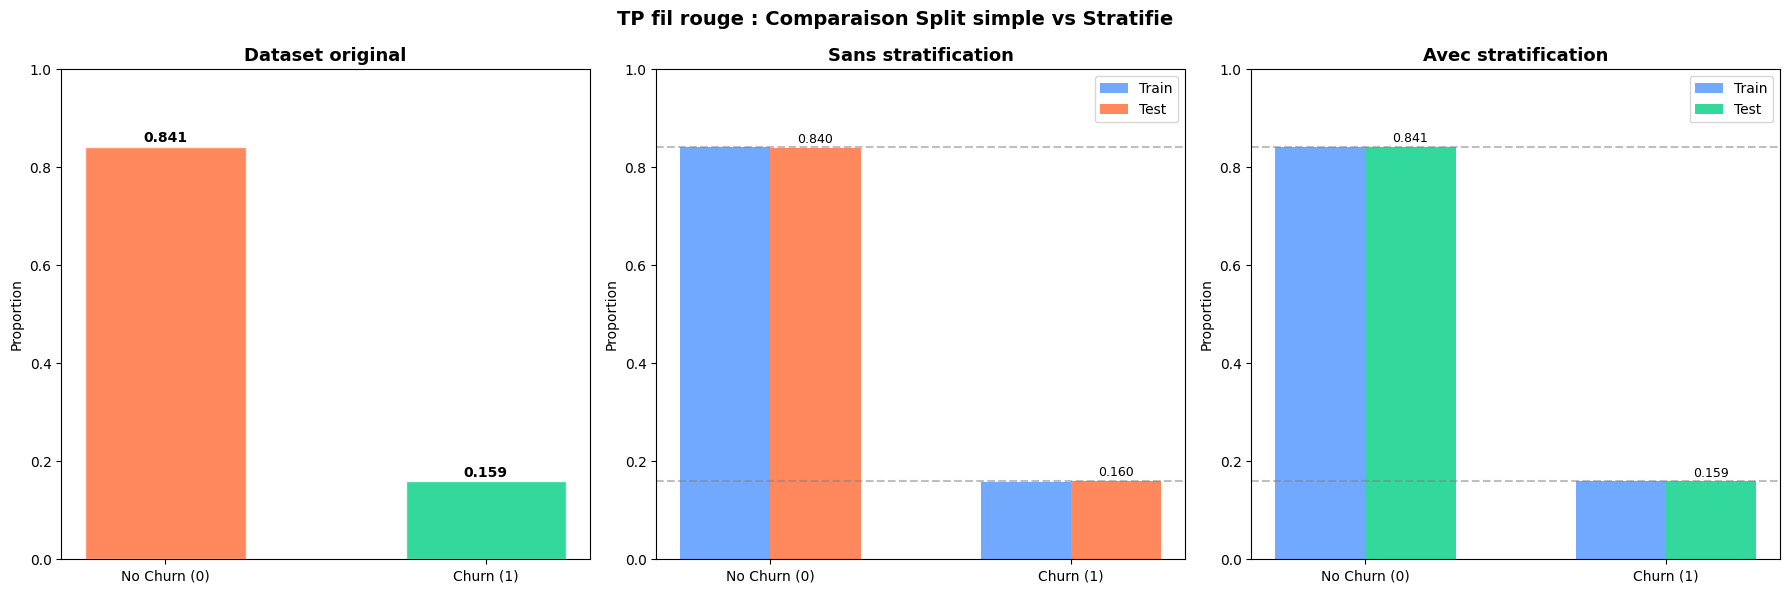

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

labels = ["No Churn (0)", "Churn (1)"]
x = np.arange(len(labels))
width = 0.3

bars = axes[0].bar(
    x,
    original_props,
    width=0.5,
    color=["#ff6b35", "#00d084"],
    alpha=0.8,
    edgecolor="white",
)
axes[0].set_title("Dataset original", fontsize=13, fontweight="bold")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("Proportion")
axes[0].set_ylim(0, 1)
for bar, prop in zip(bars, original_props):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{prop:.3f}",
        ha="center",
        fontweight="bold",
    )


bars_train = axes[1].bar(
    x - width / 2,
    train_props,
    width,
    label="Train",
    color="#4d94ff",
    alpha=0.8,
)
bars_test = axes[1].bar(
    x + width / 2,
    test_props,
    width,
    label="Test",
    color="#ff6b35",
    alpha=0.8,
)
axes[1].axhline(y=original_props[0], color="gray", linestyle="--", alpha=0.5)
axes[1].axhline(y=original_props[1], color="gray", linestyle="--", alpha=0.5)
axes[1].set_title("Sans stratification", fontsize=13, fontweight="bold")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Proportion")
axes[1].set_ylim(0, 1)
axes[1].legend()
for bar, prop in zip(bars_test, test_props):
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{prop:.3f}",
        ha="center",
        fontsize=9,
    )

bars_train_s = axes[2].bar(
    x - width / 2,
    train_props_s,
    width,
    label="Train",
    color="#4d94ff",
    alpha=0.8,
)
bars_test_s = axes[2].bar(
    x + width / 2,
    test_props_s,
    width,
    label="Test",
    color="#00d084",
    alpha=0.8,
)
axes[2].axhline(y=original_props[0], color="gray", linestyle="--", alpha=0.5)
axes[2].axhline(y=original_props[1], color="gray", linestyle="--", alpha=0.5)
axes[2].set_title("Avec stratification", fontsize=13, fontweight="bold")
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
axes[2].set_ylabel("Proportion")
axes[2].set_ylim(0, 1)
axes[2].legend()
for bar, prop in zip(bars_test_s, test_props_s):
    axes[2].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{prop:.3f}",
        ha="center",
        fontsize=9,
    )

plt.suptitle(
    "TP fil rouge : Comparaison Split simple vs Stratifie",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

## Pipeline sklearn et prévention du Data Leakage

### Construction de la pipeline

Le dataset UK Retail contient des colonnes numériques et catégorielles avec des valeurs manquantes. Vous devez construire une pipeline complète qui prend en charge tout le preprocessing.

1. Identifiez les colonnes numériques et catégorielles pertinentes pour la prédiction.

In [33]:
num_features = X.select_dtypes(include=np.number).columns.to_list()
cat_features = X.select_dtypes(include="object").columns.to_list()
date_features = X.select_dtypes(include="datetime").columns.to_list()

print("Numeriques : ", num_features)
print("Catégoriques : ", cat_features)
print("Date : ", date_features)

Numeriques :  ['Quantity', 'UnitPrice']
Catégoriques :  ['Country']
Date :  ['InvoiceDate']


2. Construisez un `ColumnTransformer` avec :
   - Pour les colonnes **numériques** : imputation par la médiane + standardisation
   - Pour les colonnes **catégorielles** : imputation par la valeur la plus fréquente + encodage one-hot

In [34]:
def add_cyclical_features(X):
    X = pd.DataFrame(X).copy()

    month = X.iloc[:, 0].dt.month
    X["month_sin"] = np.sin(2 * np.pi * month / 12)
    X["month_cos"] = np.cos(2 * np.pi * month / 12)

    return X[["month_sin", "month_cos"]]


def extract_date_features(X):
    X = pd.DataFrame(X).copy()
    original_cols = X.columns

    for col in X.columns:
        X[col + "_year"] = X[col].dt.year
        X[col + "_month"] = X[col].dt.month
        X[col + "_day"] = X[col].dt.day
        X[col + "_dayofweek"] = X[col].dt.dayofweek

    return X.drop(columns=original_cols)


num_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

date_pipeline = Pipeline(
    steps=[
        ("date_features", FunctionTransformer(extract_date_features)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_features),
        ("num", num_pipeline, num_features),
        ("date", date_pipeline, date_features),
    ]
)

3. Intégrez ce preprocessor dans une `Pipeline` complète avec un premier modèle de votre choix.

In [35]:
lr_clf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LogisticRegression()),
    ]
)

lr_clf_model = lr_clf_pipeline.fit(X_train_s, y_train_s)

y_pred_lr_clf = lr_clf_model.predict(X_test_s)

print("Accuracy : ", accuracy_score(y_test_s, y_pred_lr_clf))

Accuracy :  0.8439262459381731


c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Cross-Validation

### Mise en place

1. Instanciez **plusieurs modèles de classification**.

In [36]:
models = {
    "LogisticRegression": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "regressor",
                LogisticRegression(
                    # solver="saga",
                    # penalty="l2",
                    max_iter=1000,
                    # tol=1e-3,
                    random_state=42,
                ),
            ),
        ]
    ),
    "DecisionTreeClassifier": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "regressor",
                DecisionTreeClassifier(
                    random_state=42,
                    max_depth=10,
                    min_samples_leaf=10,
                    max_features="sqrt",
                    criterion="gini",
                ),
            ),
        ]
    ),
    "RandomForestClassifier": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "regressor",
                RandomForestClassifier(
                    random_state=42,
                    n_estimators=20,
                    # max_depth=10,
                    # max_features="sqrt",
                    # min_samples_leaf=5,
                    n_jobs=-1,
                ),
            ),
        ]
    ),
    "GradientBoostingClassifier": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "regressor",
                GradientBoostingClassifier(
                    random_state=42,
                    n_estimators=20,
                    learning_rate=0.1,
                    max_depth=3,
                    subsample=0.8,
                    max_features="sqrt",
                ),
            ),
        ]
    ),
}

2. Appliquez une **KFold** (5 splits) et une **StratifiedKFold** (5 splits) sur les données.

In [37]:
folds = {
    "skf5": StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    "skf10": StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    "kf5": KFold(n_splits=5, shuffle=True, random_state=42),
    "kf10": KFold(n_splits=10, shuffle=True, random_state=42),
}

scoring = ["accuracy", "f1_macro"]

3. Calculez l'accuracy moyenne et l'écart-type pour chaque méthode.

In [38]:
results_table = []
all_scores = {}

for model_name, model in models.items():
    for fold_name, cv_strategy in folds.items():
        cv_results = cross_validate(
            model, X, y, cv=cv_strategy, scoring=scoring, return_train_score=True
        )

        test_acc = cv_results["test_accuracy"]
        test_f1 = cv_results["test_f1_macro"]
        train_acc = cv_results["train_accuracy"]
        fit_time = cv_results["fit_time"]

        key = f"{model_name}\n({fold_name})"
        all_scores[key] = test_acc

        results_table.append(
            {
                "model": model_name,
                "cv": fold_name,
                "test_acc_mean": test_acc.mean(),
                "test_acc_std": test_acc.std(),
                "test_f1_mean": test_f1.mean(),
                "test_f1_std": test_f1.std(),
                "train_acc_mean": train_acc.mean(),
                "fit_time_mean": fit_time.mean(),
            }
        )

        acc_str = f"{test_acc.mean():.4f} +/- {test_acc.std():.4f}"
        f1_str = f"{test_f1.mean():.4f} +/- {test_f1.std():.4f}"
        print(f"{model_name} {fold_name} accuracy : {acc_str} | f1 : {f1_str}")

LogisticRegression skf5 accuracy : 0.8432 +/- 0.0002 | f1 : 0.4772 +/- 0.0010
LogisticRegression skf10 accuracy : 0.8433 +/- 0.0003 | f1 : 0.4770 +/- 0.0015
LogisticRegression kf5 accuracy : 0.8433 +/- 0.0019 | f1 : 0.4767 +/- 0.0016
LogisticRegression kf10 accuracy : 0.8432 +/- 0.0022 | f1 : 0.4764 +/- 0.0020
DecisionTreeClassifier skf5 accuracy : 0.8432 +/- 0.0003 | f1 : 0.4730 +/- 0.0028
DecisionTreeClassifier skf10 accuracy : 0.8432 +/- 0.0004 | f1 : 0.4806 +/- 0.0066
DecisionTreeClassifier kf5 accuracy : 0.8435 +/- 0.0020 | f1 : 0.4737 +/- 0.0031
DecisionTreeClassifier kf10 accuracy : 0.8435 +/- 0.0021 | f1 : 0.4763 +/- 0.0056
RandomForestClassifier skf5 accuracy : 0.8533 +/- 0.0009 | f1 : 0.6810 +/- 0.0021
RandomForestClassifier skf10 accuracy : 0.8553 +/- 0.0016 | f1 : 0.6851 +/- 0.0037
RandomForestClassifier kf5 accuracy : 0.8536 +/- 0.0004 | f1 : 0.6827 +/- 0.0025
RandomForestClassifier kf10 accuracy : 0.8552 +/- 0.0018 | f1 : 0.6840 +/- 0.0043
GradientBoostingClassifier skf5 

4. Comparez les résultats et visualisez les scores par fold sous forme de barres groupées.

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_25028\351403111.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data, labels=labels, patch_artist=True, widths=0.6)


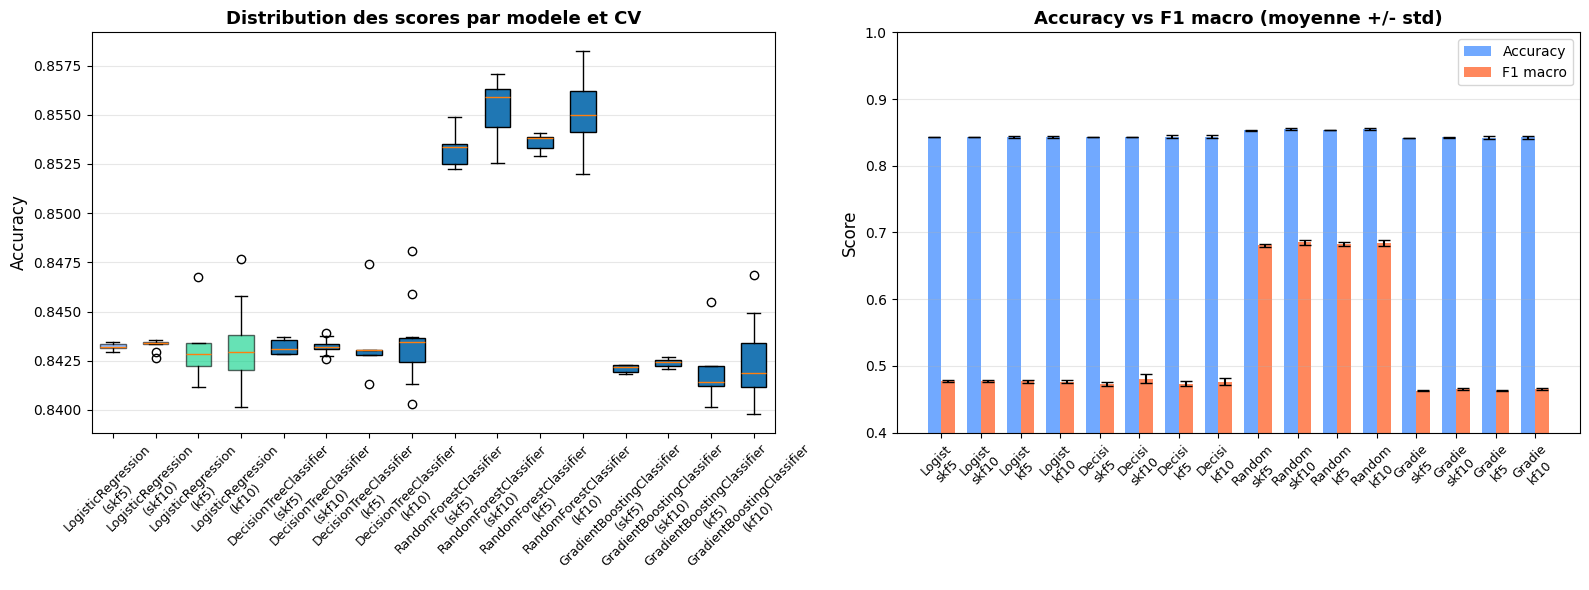

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

labels = list(all_scores.keys())
data = list(all_scores.values())

bp = axes[0].boxplot(data, labels=labels, patch_artist=True, widths=0.6)
colors = ["#4d94ff", "#4d94ff", "#00d084", "#00d084"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].set_title(
    "Distribution des scores par modele et CV", fontsize=13, fontweight="bold"
)
axes[0].grid(True, alpha=0.3, axis="y")
axes[0].tick_params(axis="x", labelsize=9, rotation=45)


x = np.arange(len(results_table))
width = 0.35

acc_means = [r["test_acc_mean"] for r in results_table]
acc_stds = [r["test_acc_std"] for r in results_table]
f1_means = [r["test_f1_mean"] for r in results_table]
f1_stds = [r["test_f1_std"] for r in results_table]

bars1 = axes[1].bar(
    x - width / 2,
    acc_means,
    width,
    yerr=acc_stds,
    label="Accuracy",
    color="#4d94ff",
    alpha=0.8,
    capsize=4,
)
bars2 = axes[1].bar(
    x + width / 2,
    f1_means,
    width,
    yerr=f1_stds,
    label="F1 macro",
    color="#ff6b35",
    alpha=0.8,
    capsize=4,
)

xlabels = [f"{r['model'][:6]}\n{r['cv']}" for r in results_table]
axes[1].set_xticks(x)
axes[1].set_xticklabels(xlabels, fontsize=9, rotation=45)
axes[1].set_ylabel("Score", fontsize=12)
axes[1].set_title(
    "Accuracy vs F1 macro (moyenne +/- std)", fontsize=13, fontweight="bold"
)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis="y")
axes[1].set_ylim(0.4, 1)

plt.tight_layout()
plt.show()

5. Utilisez `cross_validate` avec la StratifiedKFold pour récupérer simultanément l'accuracy, le F1-score macro, la précision et le rappel, sur le train **et** le test.

6. Affichez les résultats et identifiez si les modèles présentent des signes de surapprentissage.

In [40]:
df_result = pd.DataFrame(results_table)
df_result.head(10)

,model,cv,test_acc_mean,test_acc_std,test_f1_mean,test_f1_std,train_acc_mean,fit_time_mean
0,LogisticRegression,skf5,0.843221,0.000170,0.477235,0.001044,0.843260,1.897985
1,LogisticRegression,skf10,0.843298,0.000266,0.476961,0.001528,0.843333,2.010878
2,LogisticRegression,kf5,0.843278,0.001884,0.476685,0.001577,0.843275,2.295261
3,LogisticRegression,kf10,0.843159,0.002158,0.476365,0.002015,0.843200,1.884989
4,DecisionTreeClassifier,skf5,0.843214,0.000348,0.472970,0.002788,0.843382,0.383321
5,DecisionTreeClassifier,skf10,0.843231,0.000382,0.480602,0.006600,0.843391,0.434099
6,DecisionTreeClassifier,kf5,0.843530,0.002040,0.473665,0.003052,0.843566,0.389128
7,DecisionTreeClassifier,kf10,0.843495,0.002087,0.476322,0.005617,0.843556,0.430098
8,RandomForestClassifier,skf5,0.853303,0.000935,0.680994,0.002133,0.907017,1.139347
9,RandomForestClassifier,skf10,0.855300,0.001584,0.685050,0.003696,0.905179,1.281461


- Pas de signe de surapprentissage.

7. Comparez les performances de chaque modèle dans un tableau de synthèse et identifiez le meilleur candidat.

- Meilleur modèle : RandomForestClassifier